In [734]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.preprocessing import OneHotEncoder

import os
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import os
import pathlib
import codecs

Check which versions of Tensorflow and Sci-kit learn are in use so that documentation is easier to use when we get stuck.

In [735]:
tf.__version__, sklearn.__version__

('1.11.0', '0.19.1')

Grab MNIST data using tensorflow (this may take a minute).

In [736]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

Check out the size of each dataset. It looks like the train:test ratio is 6:1, with the test data being one column.

In [737]:
x_train.shape, x_test.shape, y_train.shape

((60000, 28, 28), (10000, 28, 28), (60000,))

In [738]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

Check the distribution of labels to ensure that we are using a balanced training set.

Text(0.5,0,'Label')

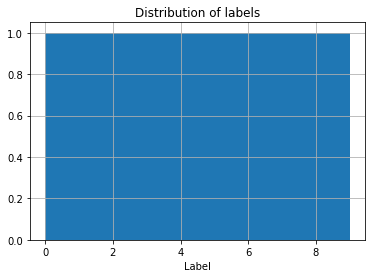

In [739]:
pd.Series(y_train).value_counts().reset_index().hist('index')
plt.title("Distribution of labels")
plt.xlabel('Label')

Since the y data has many classes, let's one-hot encode it with sci-kit learn.

In [740]:
oneH = OneHotEncoder()
oneH.fit(y_train.reshape(-1, 1))

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [741]:
ohYTest = oneH.transform(y_test.reshape(-1,1)).toarray()
ohYTrain = oneH.transform(y_train.reshape(-1,1)).toarray()

The train and test labels are now stored in sparse matrices. A quick unit test below ensures that the transformation was performed correctly. The printed data should support your intuition as to what the test is doing.

In [742]:
print("Transformed label:")
print(ohYTrain[0])
print()
print("Original label:")
print(y_train[0])

Transformed label:
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

Original label:
5


In [743]:
for i in range(y_train.shape[0]):
    assert np.argmax(ohYTrain[i]) == y_train[i]

Just for a sanity check, let's make sure the first data point is actually a 5. Matplotlib supports plotting images, so let's leverage its power.

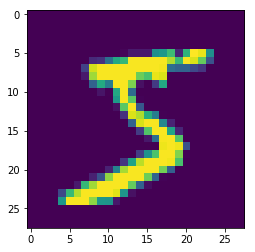

In [744]:
plt.imshow(x_train[0]);

This looks great. Let's examine the shape of each image's matrix to plan for our modelling process.

In [745]:
x_train[0].shape

(28, 28)

Let's prepare our model in tensorflow, including ensuring that the computational graph is ready to be used from scratch.

In [746]:
import keras
from keras import layers, models
from keras import backend as K

In [747]:
tf.reset_default_graph()
K.clear_session()

sess = tf.Session(graph=tf.get_default_graph())

with tf.name_scope("Model"):

    model = keras.models.Sequential()

    with tf.name_scope("Input"):
        model.add(layers.Flatten(input_shape=(28,28,)))

    with tf.name_scope("Dense1"):
        model.add(layers.Dense(300, input_shape=(784,), activation=tf.nn.leaky_relu))
        model.add(layers.Dropout(0.10))

    with tf.name_scope("Dense2"):
        model.add(layers.Dense(200, activation=tf.nn.leaky_relu))
        model.add(layers.Dropout(0.10))

    with tf.name_scope("Dense3"):
        model.add(layers.Dense(100, activation=tf.nn.leaky_relu))
        model.add(layers.Dropout(0.10))

    with tf.name_scope("Output"):
        model.add(layers.Dense(output_dim = 10 , activation=tf.nn.softmax, name="Output"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               235500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               60200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
__________

In [748]:
with tf.name_scope("tBoard_Setup"):
    tensorBoard = keras.callbacks.TensorBoard(histogram_freq=1, write_graph=True)
    #tensorBoard.set_model(model)

In [749]:
logDir = "logs"
logPath = (os.getcwd() + "/" + logDir).replace(" ", "\\ ")
print("Path for Tensorboard Logs:")
print(logPath)

Path for Tensorboard Logs:
/Users/mikelawrence/Documents/School/Data\ X/HW/HW\ 10/logs


In [750]:
with tf.name_scope("Compilation"):
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [751]:
batchSize = 100
epochs = 20

In [752]:
with tf.name_scope('Training'):
    model.fit(x=x_train, y=ohYTrain, verbose=1, shuffle=True, batch_size=batchSize, nb_epoch=epochs,
              callbacks=[tensorBoard], validation_data=(x_test, ohYTest))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 10s 163us/step - loss: 1.0547 - acc: 0.6996 - val_loss: 0.4403 - val_acc: 0.8805
Epoch 2/20
60000/60000 [==============================] - 9s 145us/step - loss: 0.4643 - acc: 0.8632 - val_loss: 0.3284 - val_acc: 0.9082
Epoch 3/20
60000/60000 [==============================] - 9s 146us/step - loss: 0.3832 - acc: 0.8857 - val_loss: 0.2900 - val_acc: 0.9174
Epoch 4/20
60000/60000 [==============================] - 9s 147us/step - loss: 0.3406 - acc: 0.8996 - val_loss: 0.2638 - val_acc: 0.9250
Epoch 5/20
60000/60000 [==============================] - 9s 147us/step - loss: 0.3093 - acc: 0.9091 - val_loss: 0.2440 - val_acc: 0.9300
Epoch 6/20
60000/60000 [==============================] - 9s 149us/step - loss: 0.2845 - acc: 0.9163 - val_loss: 0.2271 - val_acc: 0.9346
Epoch 7/20
60000/60000 [==============================] - 9s 148us/step - loss: 0.2687 - acc: 0.9218 - val_loss: 0.2129 -

In [753]:
with tf.name_scope("Evaluation"):
    print("Final Train Loss and Accuracy are:")
    print(model.evaluate(x_train, ohYTrain, verbose=0))
    print()
    print("Final Test Loss and Accuracy are:")
    print(model.evaluate(x_test, ohYTest, verbose=0))

Final Train Loss and Accuracy are:
[0.11609431128675739, 0.9661333333333333]

Final Test Loss and Accuracy are:
[0.12453132966682315, 0.9613]


In [755]:
print(logPath)

/Users/mikelawrence/Documents/School/Data\ X/HW/HW\ 10/logs


In [756]:
!tensorboard --logdir=/Users/mikelawrence/Documents/School/Data\ X/HW/HW\ 10/logs #--port=6005

Begin improved model